In [1]:
%pylab inline
import random

import numpy as np
import random
import pickle
from tqdm import tqdm
import letor_metrics
import pyximport
pyximport.install()

Populating the interactive namespace from numpy and matplotlib


(None, <pyximport.pyximport.PyxImporter at 0x10e27f470>)

In [2]:
raw_data = np.loadtxt('./data/ml-1m/ratings.dat', delimiter='::')

In [3]:
from dataset import TripletsDataset

In [4]:
ds = TripletsDataset(raw_data, threshold_user=60, threshold_item=5, rnd_seed=42)
ds.train_test_split(n_train=50)
ds.init_cached_random()

Split users:   5%|▌         | 211/3938 [00:00<00:01, 2088.88it/s]

# define model

In [5]:
import tensorflow as tf
from bprnn_wo_embedding import BPR_NN_WO_EMB

In [7]:
N_USERS = int(max(raw_data[:, 0])) + 1
N_ITEMS = int(max(raw_data[:, 1])) + 1
N_EMBEDDINGS = None # since we dont need this

In [8]:
import tensorflow.contrib.slim as slim

def inner_network_wo_embeddings(user_ids, item_ids):
    # squash users and intems with one-hot encoding
    oh_users = tf.one_hot(user_ids, depth=N_USERS)
    oh_items = tf.one_hot(item_ids, depth=N_ITEMS)
    # join them
    joined_input = tf.concat(1, [oh_users, oh_items])
    # and apply feed-forward NN
    net = slim.fully_connected(inputs=joined_input, num_outputs=64, activation_fn=tf.nn.relu)
    net = slim.fully_connected(inputs=net, num_outputs=1, activation_fn=None)
    return net

In [9]:
model = BPR_NN_WO_EMB(inner_net=inner_network_wo_embeddings)
model.build_graph()
model.initialize_session()

In [10]:
losses = []
batch_size = 512
for n_batches, cur_optim in [(2000, model.trainer_3)]:
    for i in tqdm(range(n_batches)):
        batch = ds.sample_train_batch(n_samples=batch_size)
        fd = {
            model.user_ids:  batch['users'], 
            model.left_ids:  batch['left_items'],
            model.right_ids: batch['right_items'],
            model.target_y:  batch['y'],
        }
        nl,  t, _ = model.session.run([model.net_loss,  model.target, cur_optim], feed_dict=fd)
        losses.append((nl, t))
        if i%200==0:
            print('[it {}] metrics: {}'.format(i, losses[-1]))

  0%|          | 2/2000 [00:00<08:07,  4.10it/s]

[it 0] metrics: (0.69365454, 0.69365454)


 10%|█         | 201/2000 [00:43<06:32,  4.58it/s]

[it 200] metrics: (0.5422281, 0.5422281)


 20%|██        | 402/2000 [01:26<04:57,  5.36it/s]

[it 400] metrics: (0.51621306, 0.51621306)


 30%|███       | 602/2000 [02:04<04:19,  5.39it/s]

[it 600] metrics: (0.49490207, 0.49490207)


 40%|████      | 801/2000 [02:46<04:33,  4.38it/s]

[it 800] metrics: (0.49957567, 0.49957567)


 50%|█████     | 1001/2000 [03:33<04:51,  3.43it/s]

[it 1000] metrics: (0.44693765, 0.44693765)


 60%|██████    | 1201/2000 [04:23<02:55,  4.54it/s]

[it 1200] metrics: (0.44347155, 0.44347155)


 70%|███████   | 1402/2000 [05:09<02:08,  4.67it/s]

[it 1400] metrics: (0.40260884, 0.40260884)


 80%|████████  | 1602/2000 [06:05<01:32,  4.29it/s]

[it 1600] metrics: (0.35362849, 0.35362849)


 90%|█████████ | 1802/2000 [06:58<00:39,  5.08it/s]

[it 1800] metrics: (0.36365443, 0.36365443)


100%|██████████| 2000/2000 [07:38<00:00,  5.12it/s]


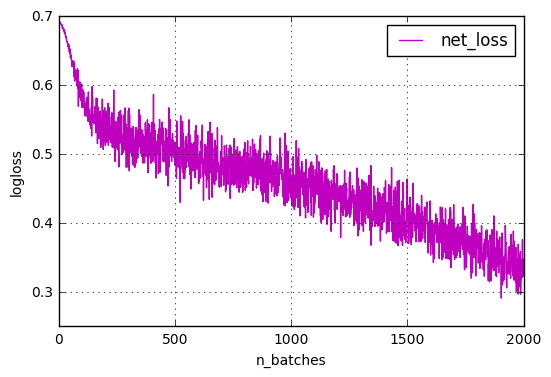

In [11]:
plot([x[0] for x in losses], c='m', label='net_loss')
grid()
legend()
xlabel('n_batches')
ylabel('logloss')

In [12]:
ndcg_vals = []
for u in tqdm(ds.data_keys, desc='Prediction', leave=True):
    fd = {
            model.user_ids:  (np.ones(len(ds.test[u]))*u).astype(np.int32), 
            model.left_ids:  np.array([i for (i, r) in ds.test[u]]).astype(np.int32),
        }
    response = model.session.run(model.left_output, feed_dict=fd)[:, 0]

    # make relevances
    relevances = np.array([r for (i, r) in ds.test[u]])
    predicted_ranking = np.argsort(-response)
    # calc score
    gain = letor_metrics.ndcg_from_ranking(relevances, predicted_ranking, 10)
    ndcg_vals.append(gain)

Prediction: 100%|██████████| 3938/3938 [01:59<00:00, 33.03it/s]


In [13]:
np.mean(ndcg_vals)

0.70941910947664699

In [14]:
model.destroy()